In [1]:
#Download the required packages that we will use for this tutorial

!pip install netCDF4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.5 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [3]:
#Download the data with wget
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/nino34.long.anom.data.txt

--2025-09-10 15:10:31--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.109, 128.55.206.106, 128.55.206.111, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.109|:80... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc [following]
--2025-09-10 15:10:31--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc’

sst.mon.mean.trefad 100%[===================>] 412.45M  23.4MB/s    in 20s     

2025-09-10 15:10:51 (20.5 MB/s) - ‘sst.mon.mean.trefadj.anom.1880to2018.nc’ s

In [ ]:
#visualize the data
'/content/sst.mon.mean.trefadj.anom.1880to2018.nc'

In [4]:
#Scaffold code to load in data.  This code cell is mostly data wrangling


def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('/content/nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time,
                                    dataset, data_format,
                                    num_input_time_steps=1,
                                    use_pca=False, n_components=32,
                                    lat_slice=None, lon_slice=None):
  """
  inputs
  ------

      start_date           str : the start date from which to extract sst
      end_date             str : the end date
      lead_time            str : the number of months between each sst
                              value and the target Nino3.4 Index
      dataset              str : 'observations' 'CNRM' or 'MPI'
      data_format          str : 'spatial' or 'flatten'. 'spatial' preserves
                                  the lat/lon dimensions and returns an
                                  array of shape (num_samples, num_input_time_steps,
                                  lat, lon).  'flatten' returns an array of shape
                                  (num_samples, num_input_time_steps*lat*lon)
      num_input_time_steps int : the number of time steps to use for each
                                 predictor sample
      use_pca             bool : whether or not to apply principal components
                              analysis to the sst field
      n_components         int : the number of components to use for PCA
      lat_slice           slice: the slice of latitudes to use
      lon_slice           slice: the slice of longitudes to use

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array the ENSO index at the specified lead time).

  """
  file_name = {'observations' : '/content/sst.mon.mean.trefadj.anom.1880to2018.nc',
               'CNRM'         : '/content/CNRM_tas_anomalies_regridded.nc',
               'MPI'          : '/content/MPI_tas_anomalies_regridded.nc'}[dataset]
  variable_name = {'observations' : 'sst',
                   'CNRM'         : 'tas',
                   'MPI'          : 'tas'}[dataset]
  ds = xr.open_dataset(file_name)
  sst = ds[variable_name].sel(time=slice(start_date, end_date))
  if lat_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("If you desire, you must implement the slicing!")
  if lon_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("If you desire, you must implement the slicing!")


  num_samples = sst.shape[0]
  #sst is a (num_samples, lat, lon) array
  #the line below converts it to (num_samples, num_input_time_steps, lat, lon)
  sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,
                                                              num_samples+1)])
  #CHALLENGE: CAN YOU IMPLEMENT THE ABOVE LINE WITHOUT A FOR LOOP?
  num_samples = sst.shape[0]

  sst[np.isnan(sst)] = 0
  if data_format=='flatten':
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.reshape(num_samples, -1)


    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(sst)
      X = pca.transform(sst)
    else:
      X = sst
  else: # data_format=='spatial'
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time+num_input_time_steps-1)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  if dataset == 'observations':
    y = load_enso_indices()[slice(start_date_plus_lead,
                                  end_date_plus_lead)]
  else: #the data is from a GCM
    X = X.astype(np.float32)
    #The Nino3.4 Index is composed of three month rolling values
    #Therefore, when calculating the Nino3.4 Index in a GCM
    #we have to extract the two months prior to the first target start date
    target_start_date_with_2_month = start_date_plus_lead - pd.DateOffset(months=2)
    subsetted_ds = ds[variable_name].sel(time=slice(target_start_date_with_2_month,
                                                   end_date_plus_lead))
    #Calculate the Nino3.4 index
    y = subsetted_ds.sel(lat=slice(5,-5), lon=slice(360-170,360-120)).mean(dim=('lat','lon'))

    y = pd.Series(y.values).rolling(window=3).mean()[2:].values
    y = y.astype(np.float32)
  ds.close()
  return X.astype(np.float32), y.astype(np.float32)


class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
               "The number of predictors must equal the number of predictands!"

    def __len__(self):
        return self.predictors.shape[0]

    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]

In [10]:
def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()


##Train a simple CNN to forecast ENSO

Let's define a simple convolutional neural network architecture. This architecture has 1 convolutional layer, followed by a pooling layer, followed by another convolutional layer, followed by three fully connected layers (called nn.Linear layers). The output of the final fully connected layer is a 1-D array, since we are trying to forecast 1 value: the target ENSO index.

In [5]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()

        #TIP: print out the dimension of the extracted features from
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Print(nn.Module):
    """
    This class prints out the size of the features
    """
    def forward(self, x):
        print(x.size())
        return x

In [6]:
def train_network(net, criterion, optimizer, trainloader, validloader, testloader,
                  experiment_name, num_epochs=20):
  """
  inputs
  ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network
                                        to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      validloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the validation dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
  outputs
  -------
      predictions (np.array), and saves the trained neural network as a .pt file
  """
  device = "cuda:0" if torch.cuda.is_available() else "cpu"
  net = net.to(device)
  best_loss = np.inf
  train_losses, valid_losses = [], []

  for epoch in range(num_epochs):
    for mode, data_loader in [('train', trainloader), ('valid', validloader)]:
      #Set the model to train mode to allow its weights to be updated
      #while training
      if mode == 'train':
        net.train()

      #Set the model to eval model to prevent its weights from being updated
      #while testing
      elif mode == 'valid':
        net.eval()

      running_loss = 0.0
      for i, data in enumerate(data_loader):
          # get a mini-batch of predictors and predictands
          batch_predictors, batch_predictands = data
          batch_predictands = batch_predictands.to(device)
          batch_predictors = batch_predictors.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          #calculate the predictions of the current neural network
          predictions = net(batch_predictors).squeeze()

          #quantify the quality of the predictions using a
          #loss function (aka criterion) that is differentiable
          loss = criterion(predictions, batch_predictands)

          if mode == 'train':
            #the 'backward pass: calculates the gradients of each weight
            #of the neural network with respect to the loss
            loss.backward()

            #the optimizer updates the weights of the neural network
            #based on the gradients calculated above and the choice
            #of optimization algorithm
            optimizer.step()

          #Save the model weights that have the best performance!


          running_loss += loss.item()
      if running_loss < best_loss and mode == 'valid':
          best_loss = running_loss
          print("saving best model")
          torch.save(net, '{}.pt'.format(experiment_name))
      print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, \
                                            running_loss/len(data_loader)))
      if mode == 'train':
          train_losses.append(running_loss/len(data_loader))
      else:
          valid_losses.append(running_loss/len(data_loader))

  net = torch.load('{}.pt'.format(experiment_name), weights_only=False)
  net.eval()
  net.to(device)

  #the remainder of this notebook calculates the predictions of the best
  #saved model
  predictions = np.asarray([])
  for i, data in enumerate(testloader):
    batch_predictors, batch_predictands = data
    batch_predictands = batch_predictands.to(device)
    batch_predictors = batch_predictors.to(device)

    batch_predictions = net(batch_predictors).squeeze()
    #Edge case: if there is 1 item in the batch, batch_predictions becomes a float
    #not a Tensor. the if statement below converts it to a Tensor
    #so that it is compatible with np.concatenate
    if len(batch_predictions.size()) == 0:
      batch_predictions = torch.Tensor([batch_predictions])
    predictions = np.concatenate([predictions, batch_predictions.detach().cpu().numpy()])
  return predictions, train_losses, valid_losses

What would happen if you removed the lines that say if mode == 'train' in the code cell below?

In [7]:
#Assemble numpy arrays corresponding to predictors and predictands
train_start_date = '1960-01-01'
train_end_date = '2005-12-31'
num_input_time_steps = 2
lead_time = 2
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date,
                      train_end_date, lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)
validation_predictors, validation_predictands = assemble_predictors_predictands(train_end_date,
                      "2007-12-31", lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands('2008-01-01',
                    '2017-12-31', lead_time, 'observations', 'spatial', num_input_time_steps=num_input_time_steps)

#Convert the numpy ararys into ENSODataset, which is a subset of the
#torch.utils.data.Dataset class.  This class is compatible with
#the torch dataloader, which allows for data loading for a CNN
train_dataset = ENSODataset(train_predictors, train_predictands)
valid_dataset = ENSODataset(validation_predictors, validation_predictands)
test_dataset = ENSODataset(test_predictors, test_predictands)

#Create a torch.utils.data.DataLoader from the ENSODatasets() created earlier!
#the similarity between the name DataLoader and Dataset in the pytorch API is unfortunate...
trainloader = DataLoader(train_dataset, batch_size=10)
validloader = DataLoader(valid_dataset, batch_size=10)
testloader = DataLoader(test_dataset, batch_size=10)
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

experiment_name = "twolayerCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net, nn.MSELoss(),
                  optimizer, trainloader, validloader, testloader, experiment_name)

/tmp/ipython-input-3972888535.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return self.predictors[idx], self.predictands[idx]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train Set: Epoch 01. loss: 0.587092
saving best model
valid Set: Epoch 01. loss: 0.519344
train Set: Epoch 02. loss: 0.263503
saving best model
valid Set: Epoch 02. loss: 0.249326
train Set: Epoch 03. loss: 0.188520
saving best model
valid Set: Epoch 03. loss: 0.234819
train Set: Epoch 04. loss: 0.117356
saving best model
valid Set: Epoch 04. loss: 0.144501
train Set: Epoch 05. loss: 0.110109
saving best model
valid Set: Epoch 05. loss: 0.122534
train Set: Epoch 06. loss: 0.147481
valid Set: Epoch 06. loss: 0.455886
train Set: Epoch 07. loss: 0.098747
valid Set: Epoch 07. loss: 0.312123
train Set: Epoch 08. loss: 0.080876
valid Set: Epoch 08. loss: 0.171396
train Set: Epoch 09. loss: 0.119002
valid Set: Epoch 09. loss: 0.125695
train Set: Epoch 10. loss: 0.124038
saving best model
valid Set: Epoch 10. loss: 0.117259
train Set: Epoch 11. loss: 0.083692
saving best model
valid Set: Epoch 11. loss: 0.115308
train Set: Epoch 12. loss: 0.083906
valid Set: Epoch 12. loss: 0.126923
train Set:

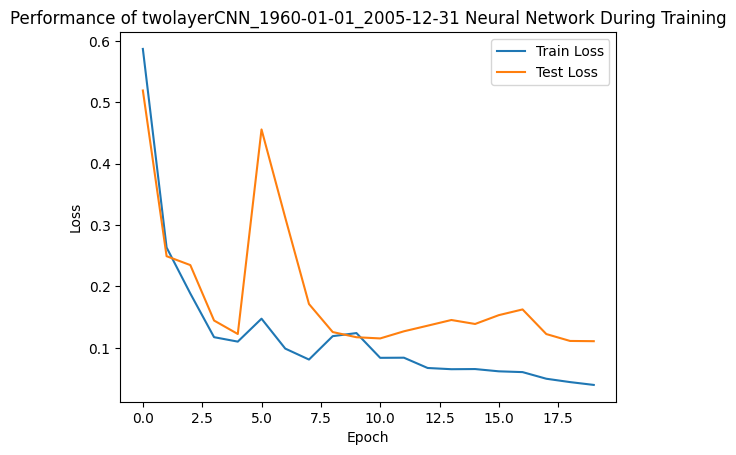

In [8]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

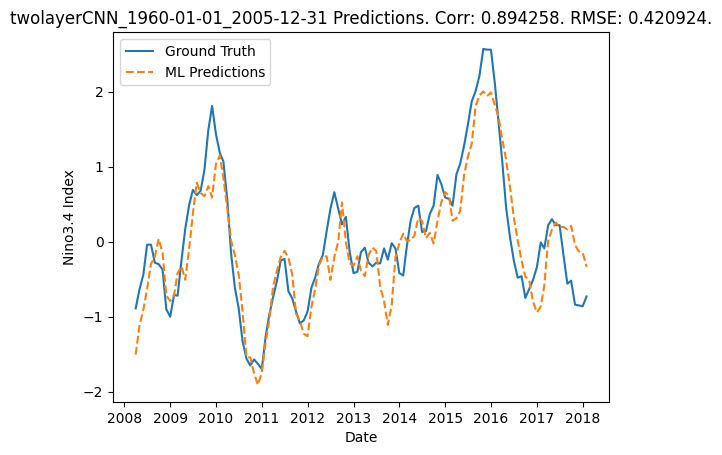

In [11]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(
    test_predictands,
    predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )

Exercise 2

⭐ Your turn!: Try reducing the number of parameters of the network. You could define your own network architecture, which uses a different number of parameters!

In [ ]:
# first we'll install a helpful library to sum our parameters
!pip install torchinfo

In [ ]:
from torchinfo import summary

# let's see how many parameters our original CNN has
summary(net)

In [ ]:
class CNNReduced(CNN):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNNReduced, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()

        #TIP: print out the dimension of the extracted features from
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 80)
        self.fc2 = nn.Linear(80, 42)
        self.fc3 = nn.Linear(42, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
class CNNReduced(CNN):
    def __init__(self, num_input_time_steps=1, print_feature_dimension=False):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
            print_feature_dimension    (bool) : whether or not to print
                                                out the dimension of the features
                                                extracted from the conv layers
        """
        super(CNNReduced, self).__init__()
        self.conv1 = nn.Conv2d(num_input_time_steps, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.print_layer = Print()

        #TIP: print out the dimension of the extracted features from
        #the conv layers for setting the dimension of the linear layer!
        #Using the print_layer, we find that the dimensions are
        #(batch_size, 16, 42, 87)
        self.fc1 = nn.Linear(16 * 42 * 87, 80)
        self.fc2 = nn.Linear(80, 42)
        self.fc3 = nn.Linear(42, 1)
        self.print_feature_dimension = print_feature_dimension

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        if self.print_feature_dimension:
          x = self.print_layer(x)
        x = x.view(-1, 16 * 42 * 87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net_reduced = CNNReduced(num_input_time_steps=num_input_time_steps)
summary(net_reduced)

In [ ]:
optimizer = optim.Adam(net_reduced.parameters(), lr=0.0001)

experiment_name = "reducedParametersCNN_{}_{}".format(train_start_date, train_end_date)
predictions, train_losses, test_losses = train_network(net_reduced, nn.MSELoss(),
                  optimizer, trainloader, testloader, experiment_name)

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Performance of {} Neural Network During Training'.format(experiment_name))
plt.legend(loc='best')
plt.show()

In [ ]:
corr, _ = pearsonr(test_predictands, predictions)
rmse = mean_squared_error(test_predictands, predictions) ** 0.5
plot_nino_time_series(
    test_predictands,
    predictions,
    '{} Predictions. Corr: {:3f}. RMSE: {:3f}.'.format(experiment_name, corr, rmse)
    )